In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
Backbone modules.
"""
from collections import OrderedDict

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision.models._utils import IntermediateLayerGetter
from typing import Dict, List

from util.misc import NestedTensor, is_main_process

from .position_encoding import build_position_encoding


class FrozenBatchNorm2d(torch.nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.

    Copy-paste from torchvision.misc.ops with added eps before rqsrt,
    without which any other models than torchvision.models.resnet[18,34,50,101]
    produce nans.
    """

    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]
    
        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias


class BackboneBase(nn.Module):

    def __init__(self, backbone: nn.Module, train_backbone: bool, num_channels: int, return_interm_layers: bool):
        super().__init__()
        for name, parameter in backbone.named_parameters():
            if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
        else:
            return_layers = {'layer4': "0"}
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.num_channels = num_channels

    def forward(self, tensor_list: NestedTensor):
        xs = self.body(tensor_list.tensors)
        out: Dict[str, NestedTensor] = {}
        for name, x in xs.items():
            m = tensor_list.mask
            assert m is not None
            mask = F.interpolate(m[None].float(), size=x.shape[-2:]).to(torch.bool)[0]
            out[name] = NestedTensor(x, mask)
        return out


class Backbone(BackboneBase):
    """ResNet backbone with frozen BatchNorm."""
    def __init__(self, name: str,
                 train_backbone: bool,
                 return_interm_layers: bool,
                 dilation: bool):
        backbone = getattr(torchvision.models, name)(
            replace_stride_with_dilation=[False, False, dilation],
            pretrained=is_main_process(), norm_layer=FrozenBatchNorm2d)
        num_channels = 512 if name in ('resnet18', 'resnet34') else 2048
        super().__init__(backbone, train_backbone, num_channels, return_interm_layers)


class Joiner(nn.Sequential):
    def __init__(self, backbone, position_embedding):
        super().__init__(backbone, position_embedding)

    def forward(self, tensor_list: NestedTensor):
        xs = self[0](tensor_list)
        out: List[NestedTensor] = []
        pos = []
        for name, x in xs.items():
            out.append(x)
            # position encoding
            pos.append(self[1](x).to(x.tensors.dtype))

        return out, pos


def build_backbone(args):
    position_embedding = build_position_encoding(args)
    train_backbone = args.lr_backbone > 0
    return_interm_layers = args.masks
    backbone = Backbone(args.backbone, train_backbone, return_interm_layers, args.dilation)
    model = Joiner(backbone, position_embedding)
    model.num_channels = backbone.num_channels
    return model


In [ ]:
from torchvision import models
from torchsummary import summary
# vgg = models.resnet50()
# summary(vgg, (3, 542, 1042))

"""
The following is an import of PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm_notebook
from tqdm import trange
import util.misc as utils


In [ ]:
input = torch.randn(1, 3, 512, 271)
print(input.size())
downsample = nn.Conv2d(3, 16, 3, stride=2, padding=1)
upsample = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1)
same = nn.Conv2d(16, 16, 3, padding=1)

h = downsample(input)
print(h.size())
s = same(h)
print(s.size())
output = upsample(s, output_size=input.size())
print(output.size())

In [ ]:
input = torch.randn(1, 3, 512, 271)
same = nn.Conv2d(3, 3, 3, padding=1)
h = same(input)
print(h.size())

In [ ]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self, imgChannels=3, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
#         self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
#         self.encConv2 = nn.Conv2d(16, 32, 5)
#         self.pool = nn.AdaptiveMaxPool2d((20, 20))

#         self.encFC1 = nn.Linear(featureDim, zDim)
#         self.encFC2 = nn.Linear(featureDim, zDim)

#         # Initializing the fully-connected layer and 2 convolutional layers for decoder
#         self.decFC1 = nn.Linear(zDim, featureDim)
#         self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
#         self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)
        
        
        self.down1 = nn.Conv2d(imgChannels, 16, 3, stride=2, padding=1)
        self.down2 = nn.Conv2d(16, 16, 3, stride=2, padding=1)
        self.down3 = nn.Conv2d(16, 16, 3, stride=2, padding=1)
        
        self.same1 = nn.Conv2d(16, 16, 3, padding=1)
        self.same2 = nn.Conv2d(16, 16, 3, padding=1)
        
        self.up1 = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
        self.up4 = nn.ConvTranspose2d(16, 32, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(32, imgChannels, 3, stride=2, padding=1)

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.down1(x))
        x = F.relu(self.down2(x))
        x = F.relu(self.down3(x))
        mu = self.same1(x)
        logVar = self.same2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.up1(z, output_size=(136, 256)))
#         x = F.relu(self.up2(z))
        x = F.relu(self.up4(x, output_size=(271, 512)))
        x = torch.sigmoid(self.up3(x, output_size=(542, 1024)))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        print("********")
        print(z.shape)
        out = self.decoder(z)
        return  mu, logVar, z

In [ ]:
net = VAE().to(device)
summary(net, (3, 542, 1024))


In [ ]:
from datasets import build_dataset, get_coco_api_from_dataset
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, DistributedSampler


In [ ]:
class Args:
    
    dataset_file = 'vae_ant'
    data_path = '/Users/cabe0006/Projects/monash/cvpr_data/detection_dataset/local_env'
    masks=False
    
args=Args()

In [ ]:
dataset_train = build_dataset(image_set='test', args=args)
# img1 = dataset_train[100][0].numpy()
# img = np.moveaxis(img1, [0, 1 ,2 ], [2, 0, 1])
# plt.imshow(img)

In [ ]:
sampler_train = torch.utils.data.RandomSampler(dataset_train)

In [ ]:
batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, 8, drop_last=True)

In [ ]:
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                   collate_fn=utils.collate_fn, num_workers=0)

In [ ]:
a = next(iter(data_loader_train))

In [ ]:
a[0].tensors.shape

# Dataset testing

In [37]:
import torch
import util.misc as utils
from datasets import build_dataset
from torch.utils.data import DataLoader, DistributedSampler
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torchvision import transforms


In [38]:
class Args:
    
    dataset_file = 'vae_ant'
    data_path = '/Users/cabe0006/Projects/monash/cvpr_data/detection_dataset/local_env'
    masks=False
    
args=Args()
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [57]:
dataset_train = build_dataset(image_set='train', args=args)
sampler_train = torch.utils.data.RandomSampler(dataset_train)
batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, 2, drop_last=True)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                    num_workers=0)

(542, 1024, 3)


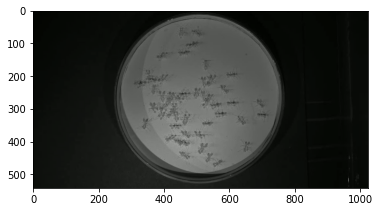

In [60]:
imgs = next(iter(data_loader_train))
inv_img = invTrans(imgs[0])
s = inv_img.numpy()
s = np.moveaxis(s, [0, 1, 2], [2, 0, 1])
print(s.shape)

plt.imshow(s)

(542, 1024, 3)


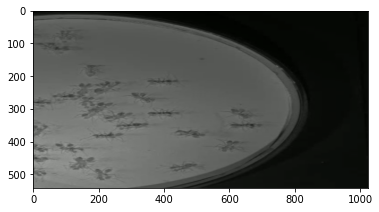

# VAE Testing

In [ ]:
import torch
q = torch.distributions.Normal(2, 4)
z = q.rsample()
print(z)

In [ ]:
p = torch.distributions.Normal(0, 1)
log_pz = p.log_prob(z)
log_qzx = q.log_prob(z)
print(f'log prob pz: {log_pz}, prob: {torch.exp(log_pz)}')
print(f'log prob pz: {log_qzx}, prob: {torch.exp(log_qzx)}')

# ResNet model

In [ ]:
import pytorch_lightning as pl
from torch import nn
import torch
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)



In [ ]:
class VAE(nn.Module):
    def __init__(self,  enc_out_dim=512, latent_dim=256, input_height=542):
        super(VAE, self).__init__()
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
#         self.decoder = resnet18_decoder(False, False)
        
    def encoder(self, x):
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        return mu, log_var

    def reparameterize(self, mu, logVar):
        # Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar / 2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [ ]:
from torchsummary import summary
# vgg = models.resnet50()
# summary(vgg, (3, 542, 1042))
vae = VAE()


In [ ]:
# summary(vae, (3, 28, 28))

In [ ]:
encoder = resnet18_encoder(False, False)

In [ ]:
inp = torch.rand(1, 3, 28, 28)

In [ ]:
encoder(inp).shape